In [1]:
import torch
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import random
import shutil

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torch.optim as optim

torch.manual_seed(1)

In [3]:
# Daniel's code
transform = transforms.Compose([transforms.Resize((480, 640)), 
                                transforms.ToTensor()])

proj_path = "/content/drive/My Drive/5_Fourth Year/Sem 1/APS360/APS360 Project/Dataset/"

train_set = torchvision.datasets.ImageFolder(
    os.path.join(proj_path, "data/train"), transform = transform)
valid_set = torchvision.datasets.ImageFolder(
    os.path.join(proj_path, "data/validation"), transform = transform)
test_set = torchvision.datasets.ImageFolder(
    os.path.join(proj_path, "data/test"), transform = transform)

# Train, Val Dataloaders are prepared in train() as the batch_size is unknown.
# Prepare Test Dataloader
# test_loader = DataLoader(test_set, batch_size=20,
#                          num_workers=1, shuffle=True)

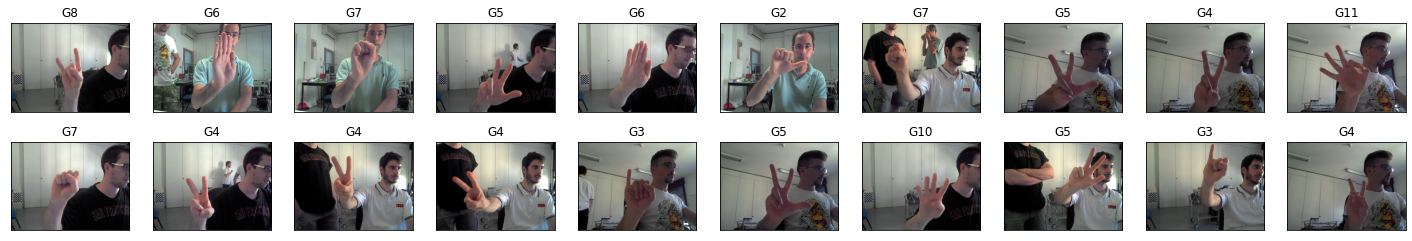

In [4]:
# Daniel's Code
# Verification Step
train_loader = DataLoader(train_set, batch_size = 27, num_workers=1, 
                          shuffle=True)
valid_loader = DataLoader(valid_set, batch_size = 27, num_workers=1, 
                          shuffle=True)
test_loader = DataLoader(test_set, batch_size = 27, num_workers=1, 
                          shuffle=True)
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
classes = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11']
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [6]:
class Baseline(nn.Module):

    def __init__(self, ch1=6, ch2=12, stride=1, hidden=64, classes=11):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(157 * 117 * 12, hidden)
        self.fc2 = nn.Linear(64, 11)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 157 * 117 * 12)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
from torchsummary import summary
model = Baseline()
model.cuda()
summary(model, (3, 480, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 476, 636]             456
         MaxPool2d-2          [-1, 6, 238, 318]               0
            Conv2d-3         [-1, 12, 234, 314]           1,812
         MaxPool2d-4         [-1, 12, 117, 157]               0
            Linear-5                   [-1, 64]      14,107,456
            Linear-6                   [-1, 11]             715
Total params: 14,110,439
Trainable params: 14,110,439
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.52
Forward/backward pass size (MB): 25.73
Params size (MB): 53.83
Estimated Total Size (MB): 83.07
----------------------------------------------------------------


In [ ]:

def get_accuracy(model, data_loader):
    """
    calcualte accuracy
    """
    correct = 0
    total = 0
    if torch.cuda.is_available():
        print("Using GPU for accuracy calculation")
        use_CUDA = True
    else:
        use_CUDA = False

    for images, labels in iter(data_loader):
        # print(labels)
        try:
            labels = torch.tensor([labels])
        except:
            pass

        if use_CUDA:
            images = images.cuda()
            labels = labels.cuda()
        
        if len(images.shape) == 3:
            model_out = model(images.unsqueeze(0))
        else:
            model_out = model(images)
        pred = model_out.max(1, keepdims=True)[1]
        #print(model_out)
        #print(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #print(labels)
        #print(correct)
        total += images.shape[0]

    return correct / total 
    
    
def train(model, train_set, valid_set, batch_size=27, num_epochs=1, learn_rate = 0.001):
    """
    train model
    """
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    losses, train_acc, val_acc, iters = [], [], [], []
    train_loader = DataLoader(train_set, batch_size = batch_size, num_workers=1, 
                          shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size = batch_size, num_workers=1, 
                          shuffle=True)

    if torch.cuda.is_available():
        use_CUDA = True
        print("Using GPU for training")
    else:
        use_CUDA = False

    for epoch in range(num_epochs):
        print("epoch", epoch)
        for i, (images, labels) in enumerate(train_loader):
            # print(labels)
            try: 
                labels = torch.tensor([labels])
            except:
                pass

            # print(images.shape, labels.shape)
            # if i % 100 == 0:
            #     print(i)

            if use_CUDA:
                # print("using GPU")
                images = images.cuda()
                labels = labels.cuda()

            # print(images.shape)
            if len(images.shape) == 3:
                model_out = model(images.unsqueeze(0))
            else:
                model_out = model(images)
            # print(model_out)
            # print(labels)
            loss = criterion(model_out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        iters.append(epoch)
        losses.append(float(loss)/batch_size)

        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))

        print('train acc: ' + str(train_acc[-1]) + ' | train loss: ' + str(float(loss)) + ' | valid acc: ' + str(val_acc[-1]))
        # print(n)
        # if n % 10  == 0:
        #    print(n)
        # n += 1

    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print('done')

Using GPU for training
epoch 0
Using GPU for accuracy calculation
Using GPU for accuracy calculation
train acc: 0.4653679653679654 | train loss: 2.144361734390259 | valid acc: 0.4147727272727273
epoch 1
Using GPU for accuracy calculation
Using GPU for accuracy calculation
train acc: 0.8625541125541125 | train loss: 0.6539570689201355 | valid acc: 0.8238636363636364
epoch 2
Using GPU for accuracy calculation
Using GPU for accuracy calculation
train acc: 0.9718614718614719 | train loss: 0.054871853440999985 | valid acc: 0.9261363636363636
epoch 3
Using GPU for accuracy calculation
Using GPU for accuracy calculation
train acc: 0.9913419913419913 | train loss: 0.025548668578267097 | valid acc: 0.9488636363636364
epoch 4
Using GPU for accuracy calculation
Using GPU for accuracy calculation
train acc: 1.0 | train loss: 0.004426274914294481 | valid acc: 0.9659090909090909
epoch 5
Using GPU for accuracy calculation
Using GPU for accuracy calculation
train acc: 1.0 | train loss: 0.0010836477158

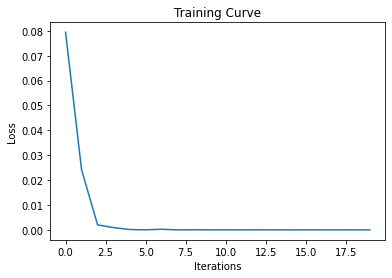

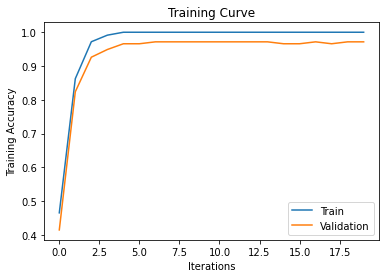

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9715909090909091
done


In [ ]:
myCNN2 = Baseline()
if torch.cuda.is_available:
    myCNN2.cuda()
train(myCNN2, train_set, valid_set, batch_size=27,  num_epochs=20)

In [ ]:
# Daniel's code:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the loader set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader\
         criterion: The loss function
     Returns:
         acc: A scalar for the avg classification accuracy over the loader set
         loss: A scalar for the average loss function over the loader set
     """
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        # calculate loss
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # calculate accuracy
        pred = outputs.max(1, keepdim=True)[1]
        total_acc += pred.eq(labels.view_as(pred)).sum().item()
        total_epoch += len(labels)
    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

In [ ]:
test_loader = DataLoader(test_set, batch_size = 27, num_workers=1, 
                          shuffle=True)
criterion = nn.CrossEntropyLoss()
test_acc, test_loss = evaluate(myCNN2, test_loader, criterion)

In [ ]:
print(test_acc, test_loss)

0.9772727272727273 0.13183016917254362
